# Realtime Streaming of Financial Data Analysis with Apache Spark (Python)


#### Download pyspark

In [1]:
!pip3 install pyspark


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425344 sha256=9c19989bc578dc5b83bf4af1c6d94e154c2355fdcb564f6ca48938e615e243f8
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


#### Import statements

In [128]:
import seaborn as sns
import matplotlib.pyplot as plt

# import statements for window functions in pyspark
from pyspark.sql import SparkSession
from pyspark.sql.window import Window
from pyspark.sql.functions import sum
from pyspark.sql.functions import avg
from pyspark.sql.functions import lag, lead
from pyspark.sql.functions import col, window

# import statements for evaluation of the Model
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.classification import LinearSVC, GBTClassifier
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.classification import DecisionTreeClassifier, RandomForestClassifier
from pyspark.ml.classification import LogisticRegression


### Data Ingestion and Processing:



In [173]:
# Initialize SparkSession
spark = SparkSession.builder.appName("FinancialTransactionsAnalysis")\
.config("spark.serializer", "org.apache.spark.serializer.KryoSerializer") \
.config("spark.executor.memory", "4g") \
    .config("spark.driver.memory", "2g") \
    .config("spark.memory.fraction", "0.6") \
    .config("spark.memory.storageFraction", "0.4") \
    .getOrCreate()



In [174]:
# Load the CSV file into a PySpark DataFrame
csv_file_path = "/content/transactions_new.csv"
df = spark.read.csv(csv_file_path, header=True, inferSchema=True)


In [175]:
# Show the schema and first few rows of the DataFrame
df.printSchema()

root
 |-- timestamp: timestamp (nullable = true)
 |-- type: string (nullable = true)
 |-- amount: double (nullable = true)
 |-- merchant_id: integer (nullable = true)
 |-- merchant_name: string (nullable = true)
 |-- merchant_latitude: double (nullable = true)
 |-- merchant_longitude: double (nullable = true)
 |-- merchant_category: string (nullable = true)
 |-- customer_id: integer (nullable = true)
 |-- customer_age: integer (nullable = true)
 |-- customer_latitude: double (nullable = true)
 |-- customer_longitude: double (nullable = true)
 |-- payment_method: string (nullable = true)
 |-- currency: string (nullable = true)
 |-- day_of_week: string (nullable = true)
 |-- time_of_day: string (nullable = true)
 |-- transaction_status: string (nullable = true)
 |-- flag_fraudulent_activity: boolean (nullable = true)
 |-- anomaly_score: double (nullable = true)
 |-- applied_discounts: double (nullable = true)
 |-- reward_points: integer (nullable = true)
 |-- transaction_channel: string 

In [176]:
df.show()

+-------------------+----------+------+-----------+-------------+-----------------+------------------+-----------------+-----------+------------+-----------------+------------------+--------------+--------+-----------+-----------+------------------+------------------------+-------------+-----------------+-------------+-------------------+--------------+-----------+--------------+------------------+---------------+
|          timestamp|      type|amount|merchant_id|merchant_name|merchant_latitude|merchant_longitude|merchant_category|customer_id|customer_age|customer_latitude|customer_longitude|payment_method|currency|day_of_week|time_of_day|transaction_status|flag_fraudulent_activity|anomaly_score|applied_discounts|reward_points|transaction_channel|app_vs_website|device_used|balance_before|     balance_after|transaction_fee|
+-------------------+----------+------+-----------+-------------+-----------------+------------------+-----------------+-----------+------------+-----------------+-

### Perform exploratory data analysis (EDA)


In [177]:
# Example: Show summary statistics for numerical columns
df.describe().show()


+-------+----------+------------------+-----------------+-------------+-------------------+------------------+-----------------+------------------+------------------+-----------------+------------------+--------------+--------+-----------+-----------+------------------+-------------------+------------------+------------------+-------------------+--------------+-----------+------------------+------------------+------------------+
|summary|      type|            amount|      merchant_id|merchant_name|  merchant_latitude|merchant_longitude|merchant_category|       customer_id|      customer_age|customer_latitude|customer_longitude|payment_method|currency|day_of_week|time_of_day|transaction_status|      anomaly_score| applied_discounts|     reward_points|transaction_channel|app_vs_website|device_used|    balance_before|     balance_after|   transaction_fee|
+-------+----------+------------------+-----------------+-------------+-------------------+------------------+-----------------+------

In [178]:
# Count the number of occurrences for each unique value in a column
df.groupBy("transaction_status").count().show()

+------------------+-----+
|transaction_status|count|
+------------------+-----+
|         completed|  344|
|          declined|  316|
|           pending|  340|
+------------------+-----+



In [179]:
# Count the number of occurrences for each unique value in a column
df.groupBy("type").count().show()

+----------+-----+
|      type|count|
+----------+-----+
|withdrawal|  329|
|  purchase|  331|
|   deposit|  340|
+----------+-----+



In [180]:
# Count fraudulent transactions
df.groupBy("flag_fraudulent_activity").count().show()

+------------------------+-----+
|flag_fraudulent_activity|count|
+------------------------+-----+
|                    true|  661|
|                   false|  339|
+------------------------+-----+



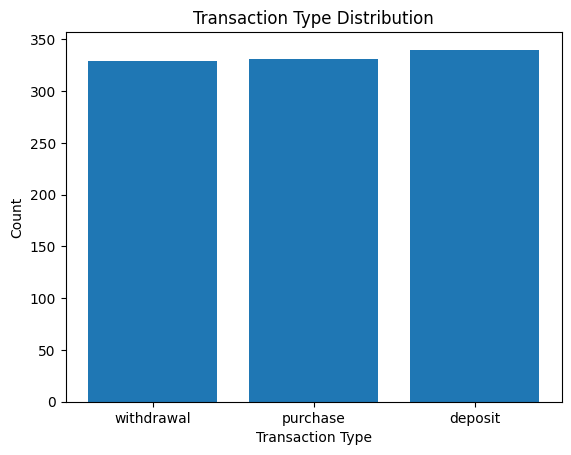

In [181]:

# Assuming 'df' is your PySpark DataFrame
transaction_type_counts = df.groupBy("type").count().toPandas()

plt.bar(transaction_type_counts["type"], transaction_type_counts["count"])
plt.title("Transaction Type Distribution")
plt.xlabel("Transaction Type")
plt.ylabel("Count")
plt.show()


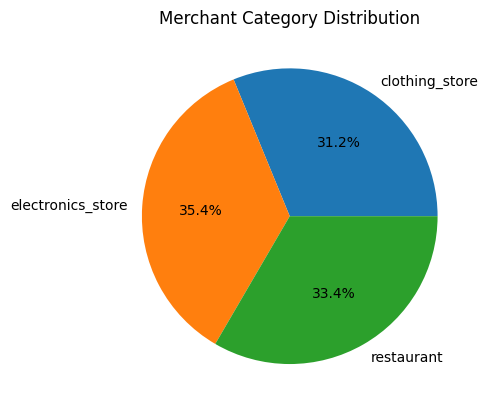

In [182]:
merchant_category_counts = df.groupBy("merchant_category").count().toPandas()

plt.pie(merchant_category_counts["count"], labels=merchant_category_counts["merchant_category"], autopct='%1.1f%%')
plt.title("Merchant Category Distribution")
plt.show()


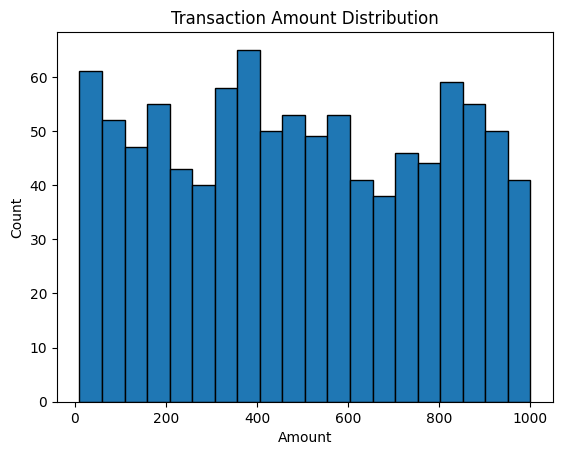

In [183]:
plt.hist(df.select("amount").toPandas()["amount"], bins=20, edgecolor="black")
plt.title("Transaction Amount Distribution")
plt.xlabel("Amount")
plt.ylabel("Count")
plt.show()


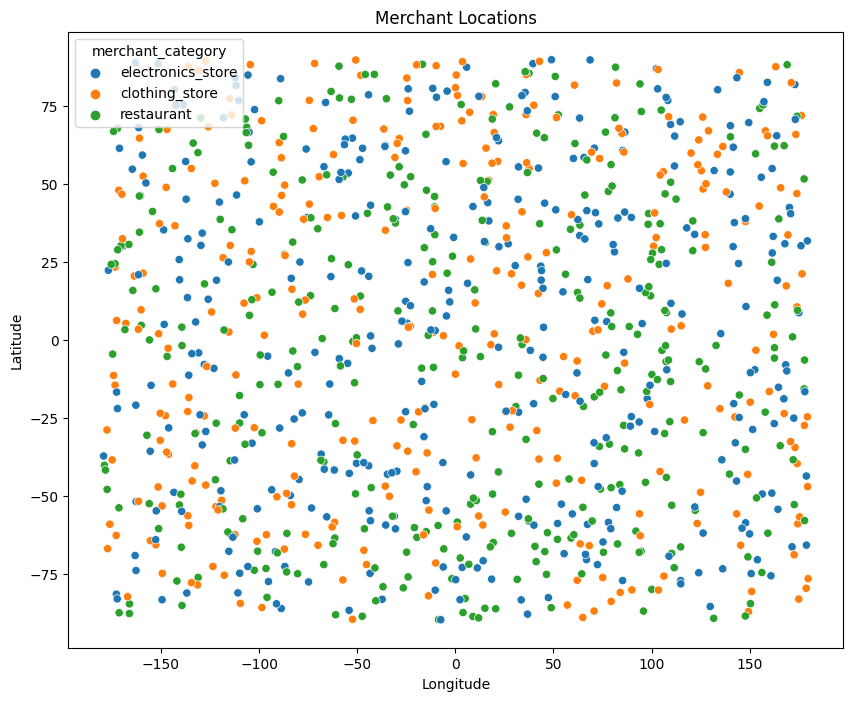

In [184]:
plt.figure(figsize=(10, 8))
sns.scatterplot(x="merchant_longitude", y="merchant_latitude", hue="merchant_category", data=df.toPandas())
plt.title("Merchant Locations")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


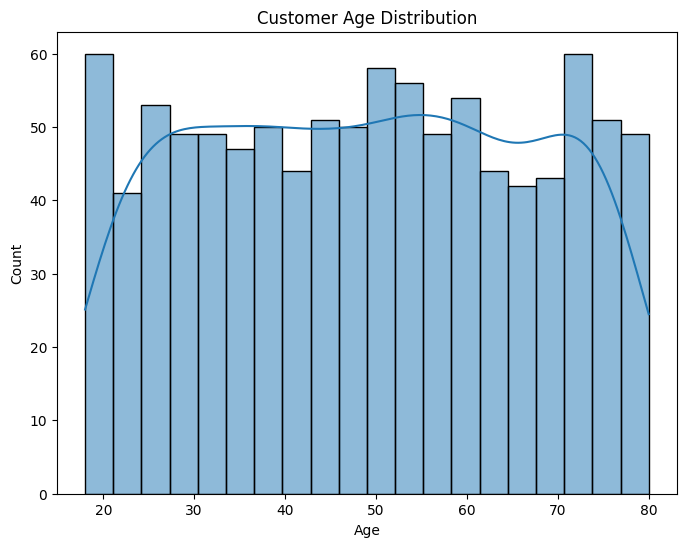

In [185]:
plt.figure(figsize=(8, 6))
sns.histplot(df.select("customer_age").toPandas()["customer_age"], bins=20, kde=True)
plt.title("Customer Age Distribution")
plt.xlabel("Age")
plt.ylabel("Count")
plt.show()


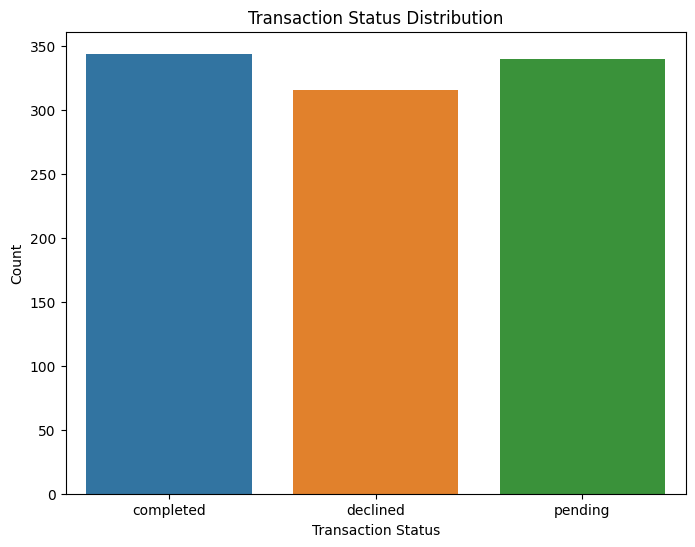

In [186]:
transaction_status_counts = df.groupBy("transaction_status").count().toPandas()

plt.figure(figsize=(8, 6))
sns.barplot(x="transaction_status", y="count", data=transaction_status_counts)
plt.title("Transaction Status Distribution")
plt.xlabel("Transaction Status")
plt.ylabel("Count")
plt.show()


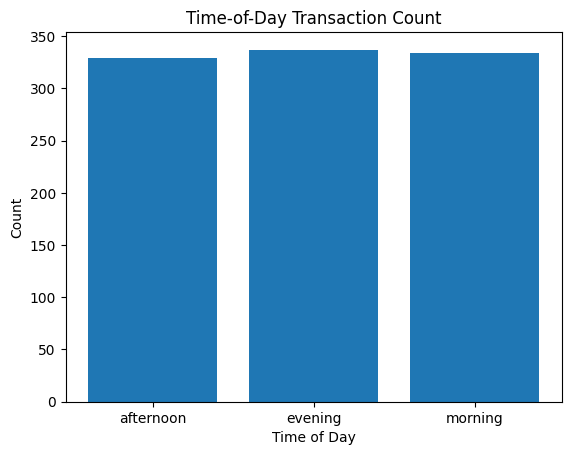

In [187]:
time_of_day_counts = df.groupBy("time_of_day").count().orderBy("time_of_day").toPandas()

plt.bar(time_of_day_counts["time_of_day"], time_of_day_counts["count"])
plt.title("Time-of-Day Transaction Count")
plt.xlabel("Time of Day")
plt.ylabel("Count")
plt.show()


### Perform time-based data aggregations using window operations


In [188]:
# Example: Aggregate transaction count per hour
result = (
    df
    .withColumn("timestamp", col("timestamp").cast("timestamp"))  # Ensure timestamp is of type timestamp
    .groupBy(window("timestamp", "2 minutes"))  # 5 minutes window
    .count()
)

# Show the result of the time-based aggregation
result.show(truncate=False)


+------------------------------------------+-----+
|window                                    |count|
+------------------------------------------+-----+
|{2023-11-29 10:24:00, 2023-11-29 10:26:00}|119  |
|{2023-11-29 10:18:00, 2023-11-29 10:20:00}|97   |
|{2023-11-30 14:20:00, 2023-11-30 14:22:00}|70   |
|{2023-11-30 14:28:00, 2023-11-30 14:30:00}|71   |
|{2023-11-30 14:26:00, 2023-11-30 14:28:00}|120  |
|{2023-11-30 14:24:00, 2023-11-30 14:26:00}|119  |
|{2023-11-29 10:20:00, 2023-11-29 10:22:00}|119  |
|{2023-11-29 10:22:00, 2023-11-29 10:24:00}|120  |
|{2023-11-30 14:22:00, 2023-11-30 14:24:00}|120  |
|{2023-11-29 10:26:00, 2023-11-29 10:28:00}|45   |
+------------------------------------------+-----+



In [189]:
# Define the window specification for rolling sum
rolling_sum_window = Window.orderBy("timestamp").rowsBetween(-2, 0)  # Sum of the current and the two preceding rows

# Calculate rolling sum of 'amount' per hour
df.withColumn("rolling_sum_amount", sum("amount").over(rolling_sum_window)).show()


+-------------------+----------+------+-----------+-------------+-----------------+------------------+-----------------+-----------+------------+-----------------+------------------+--------------+--------+-----------+-----------+------------------+------------------------+-------------+-----------------+-------------+-------------------+--------------+-----------+--------------+------------------+---------------+------------------+
|          timestamp|      type|amount|merchant_id|merchant_name|merchant_latitude|merchant_longitude|merchant_category|customer_id|customer_age|customer_latitude|customer_longitude|payment_method|currency|day_of_week|time_of_day|transaction_status|flag_fraudulent_activity|anomaly_score|applied_discounts|reward_points|transaction_channel|app_vs_website|device_used|balance_before|     balance_after|transaction_fee|rolling_sum_amount|
+-------------------+----------+------+-----------+-------------+-----------------+------------------+-----------------+------

In [190]:

# Define the window specification for running average
running_avg_window = Window.orderBy("timestamp").rowsBetween(Window.unboundedPreceding, 0)  # Includes all preceding rows up to the current row

# Calculate running average of 'balance_before' per day
df.withColumn("running_avg_balance_before", avg("balance_before").over(running_avg_window)).show()


+-------------------+----------+------+-----------+-------------+-----------------+------------------+-----------------+-----------+------------+-----------------+------------------+--------------+--------+-----------+-----------+------------------+------------------------+-------------+-----------------+-------------+-------------------+--------------+-----------+--------------+------------------+---------------+--------------------------+
|          timestamp|      type|amount|merchant_id|merchant_name|merchant_latitude|merchant_longitude|merchant_category|customer_id|customer_age|customer_latitude|customer_longitude|payment_method|currency|day_of_week|time_of_day|transaction_status|flag_fraudulent_activity|anomaly_score|applied_discounts|reward_points|transaction_channel|app_vs_website|device_used|balance_before|     balance_after|transaction_fee|running_avg_balance_before|
+-------------------+----------+------+-----------+-------------+-----------------+------------------+--------

Lag Function:

The lag function retrieves the value of a column for the previous row within a specified window.
In the example provided, it calculates the lag of the 'amount' column within the window ordered by the 'timestamp' column.
This means that for each row, it returns the 'amount' value from the preceding row in the specified order.
Lead Function:

The lead function retrieves the value of a column for the next row within a specified window.
Similarly, in the example, it calculates the lead of the 'amount' column within the window ordered by the 'timestamp' column.
This means that for each row, it returns the 'amount' value from the following row in the specified order.

In [191]:

# Define the window specification for lag and lead
lag_lead_window = Window.orderBy("timestamp")

# Calculate lag and lead of 'amount' per hour
df.withColumn("lag_amount", lag("amount").over(lag_lead_window)).withColumn("lead_amount", lead("amount").over(lag_lead_window)).show()


+-------------------+----------+------+-----------+-------------+-----------------+------------------+-----------------+-----------+------------+-----------------+------------------+--------------+--------+-----------+-----------+------------------+------------------------+-------------+-----------------+-------------+-------------------+--------------+-----------+--------------+------------------+---------------+----------+-----------+
|          timestamp|      type|amount|merchant_id|merchant_name|merchant_latitude|merchant_longitude|merchant_category|customer_id|customer_age|customer_latitude|customer_longitude|payment_method|currency|day_of_week|time_of_day|transaction_status|flag_fraudulent_activity|anomaly_score|applied_discounts|reward_points|transaction_channel|app_vs_website|device_used|balance_before|     balance_after|transaction_fee|lag_amount|lead_amount|
+-------------------+----------+------+-----------+-------------+-----------------+------------------+----------------

### Machine Learning


To utilize Spark MLlib to create and apply a machine learning model, we first need to define a specific task or goal. Let's consider a binary classification task where we want to predict whether a transaction is fraudulent or not based on the provided features.

In [192]:
# Assuming these are your categorical columns
categorical_columns = ["type", "merchant_category", "payment_method", "currency", "day_of_week", "time_of_day", "transaction_status", "transaction_channel", "app_vs_website", "device_used"]

# Create a list for the indexed and encoded columns
indexed_columns = [f"{col}_index" for col in categorical_columns]
encoded_columns = [f"{col}_encoded" for col in categorical_columns]

# Create indexers for each categorical column
indexers = [StringIndexer(inputCol=col, outputCol=indexed_col, handleInvalid="skip") for col, indexed_col in zip(categorical_columns, indexed_columns)]

# Create one-hot encoders for each indexed column
encoders = [OneHotEncoder(inputCol=indexed_col, outputCol=encoded_col) for indexed_col, encoded_col in zip(indexed_columns, encoded_columns)]

# Assemble numerical and encoded categorical features into a vector
feature_columns_numerical = ["amount", "customer_age", "merchant_latitude", "merchant_longitude", "customer_latitude", "customer_longitude", "anomaly_score", "applied_discounts", "reward_points", "balance_before", "balance_after", "transaction_fee"]
assembler = VectorAssembler(inputCols=feature_columns_numerical + encoded_columns, outputCol="features")

# Convert boolean labels to numeric
df = df.withColumn("fraud_label", col("flag_fraudulent_activity").cast("integer"))

# Create a pipeline to execute transformations
pipeline = Pipeline(stages=indexers + encoders + [assembler])

# Fit and transform the data
model = pipeline.fit(df)
df_transformed = model.transform(df)

# Select features and target variable
data = df_transformed.select("features", "fraud_label")


In [193]:

# Split the Data into Training and Testing Sets
(training_data, testing_data) = data.randomSplit([0.6, 0.4], seed=32)
evaluator = BinaryClassificationEvaluator(labelCol="fraud_label")


In [194]:

# Train and Evaluate Logistic Regression
lr = LogisticRegression(featuresCol="features", labelCol="fraud_label", maxIter=100, regParam=0.5, elasticNetParam=0.8)
lr_model = lr.fit(training_data)
lr_predictions = lr_model.transform(testing_data)

# Evaluate Logistic Regression
lr_evaluator = BinaryClassificationEvaluator(labelCol="fraud_label")
lr_accuracy = lr_evaluator.evaluate(lr_predictions)

print(f"Logistic Regression Accuracy: {lr_accuracy}")

# Precision and Recall for Logistic Regression
lr_evaluator_multi = MulticlassClassificationEvaluator(labelCol="fraud_label", metricName="weightedPrecision")
lr_precision = lr_evaluator_multi.evaluate(lr_predictions)

lr_evaluator_recall = MulticlassClassificationEvaluator(labelCol="fraud_label", metricName="weightedRecall")
lr_recall = lr_evaluator_recall.evaluate(lr_predictions)

print(f"Logistic Regression Precision: {lr_precision}")
print(f"Logistic Regression Recall: {lr_recall}")




Logistic Regression Accuracy: 0.5
Logistic Regression Precision: 0.50761092658418
Logistic Regression Recall: 0.712468193384224


In [195]:
# Train and Evaluate Decision Tree
dt = DecisionTreeClassifier(featuresCol="features", labelCol="fraud_label", maxDepth=5)
dt_model = dt.fit(training_data)
dt_predictions = dt_model.transform(testing_data)

# Evaluate Decision Tree
dt_evaluator = BinaryClassificationEvaluator(labelCol="fraud_label")
dt_accuracy = dt_evaluator.evaluate(dt_predictions)

print(f"Decision Tree Accuracy: {dt_accuracy}")

# Precision and Recall for Decision Tree
dt_evaluator_multi = MulticlassClassificationEvaluator(labelCol="fraud_label", metricName="weightedPrecision")
dt_precision = dt_evaluator_multi.evaluate(dt_predictions)

dt_evaluator_recall = MulticlassClassificationEvaluator(labelCol="fraud_label", metricName="weightedRecall")
dt_recall = dt_evaluator_recall.evaluate(dt_predictions)

print(f"Decision Tree Precision: {dt_precision}")
print(f"Decision Tree Recall: {dt_recall}")



Decision Tree Accuracy: 0.5354614412136537
Decision Tree Precision: 0.5932751584614049
Decision Tree Recall: 0.6666666666666666


In [196]:


# Train and Evaluate Random Forest
rf = RandomForestClassifier(featuresCol="features", labelCol="fraud_label", numTrees=100)
rf_model = rf.fit(training_data)
rf_predictions = rf_model.transform(testing_data)

# Evaluate Random Forest
rf_evaluator = BinaryClassificationEvaluator(labelCol="fraud_label")
rf_accuracy = rf_evaluator.evaluate(rf_predictions)

print(f"Random Forest Accuracy: {rf_accuracy}")

# Precision and Recall for Random Forest
rf_evaluator_multi = MulticlassClassificationEvaluator(labelCol="fraud_label", metricName="weightedPrecision")
rf_precision = rf_evaluator_multi.evaluate(rf_predictions)

rf_evaluator_recall = MulticlassClassificationEvaluator(labelCol="fraud_label", metricName="weightedRecall")
rf_recall = rf_evaluator_recall.evaluate(rf_predictions)

print(f"Random Forest Precision: {rf_precision}")
print(f"Random Forest Recall: {rf_recall}")


Random Forest Accuracy: 0.511378002528445
Random Forest Precision: 0.6326611331159842
Random Forest Recall: 0.7099236641221374


In [197]:

# Train and Evaluate Support Vector Machine (SVM)
svm = LinearSVC(featuresCol="features", labelCol="fraud_label", maxIter=10, regParam=0.1)
svm_model = svm.fit(training_data)
svm_predictions = svm_model.transform(testing_data)

# Evaluate SVM
svm_evaluator = BinaryClassificationEvaluator(labelCol="fraud_label")
svm_accuracy = svm_evaluator.evaluate(svm_predictions)

print(f"SVM Accuracy: {svm_accuracy}")

# Evaluate SVM
svm_evaluator = MulticlassClassificationEvaluator(labelCol="fraud_label", metricName="weightedPrecision")
svm_precision = svm_evaluator.evaluate(svm_predictions)

svm_evaluator = MulticlassClassificationEvaluator(labelCol="fraud_label", metricName="weightedRecall")
svm_recall = svm_evaluator.evaluate(svm_predictions)

print(f"SVM Precision: {svm_precision}")
print(f"SVM Recall: {svm_recall}")



SVM Accuracy: 0.5221238938053097
SVM Precision: 0.50761092658418
SVM Recall: 0.712468193384224


In [198]:
# Train and Evaluate Gradient Boosted Tree
gbt = GBTClassifier(featuresCol="features", labelCol="fraud_label", maxDepth=5, maxIter=50)
gbt_model = gbt.fit(training_data)
gbt_predictions = gbt_model.transform(testing_data)

# Evaluate GBT
gbt_evaluator = BinaryClassificationEvaluator(labelCol="fraud_label")
gbt_accuracy = gbt_evaluator.evaluate(gbt_predictions)

print(f"Gradient Boosted Tree Accuracy: {gbt_accuracy}")

# Evaluate GBT
gbt_evaluator = MulticlassClassificationEvaluator(labelCol="fraud_label", metricName="weightedPrecision")
gbt_precision = gbt_evaluator.evaluate(gbt_predictions)

gbt_evaluator = MulticlassClassificationEvaluator(labelCol="fraud_label", metricName="weightedRecall")
gbt_recall = gbt_evaluator.evaluate(gbt_predictions)

print(f"GBT Precision: {gbt_precision}")
print(f"GBT Recall: {gbt_recall}")

Gradient Boosted Tree Accuracy: 0.4899494310998735
GBT Precision: 0.5948915348339038
GBT Recall: 0.6183206106870229


In [199]:
# Train and Evaluate Support Vector Machine with RBF kernel
svm_rbf = LinearSVC(featuresCol="features", labelCol="fraud_label", maxIter=10, regParam=0.1, standardization=False)
svm_rbf_model = svm_rbf.fit(training_data)
svm_rbf_predictions = svm_rbf_model.transform(testing_data)

# Evaluate SVM with RBF kernel
svm_rbf_evaluator = BinaryClassificationEvaluator(labelCol="fraud_label")
svm_rbf_accuracy = svm_rbf_evaluator.evaluate(svm_rbf_predictions)

print(f"SVM with RBF Kernel Accuracy: {svm_rbf_accuracy}")

# Evaluate svm_rbf
svm_rbf_evaluator = MulticlassClassificationEvaluator(labelCol="fraud_label", metricName="weightedPrecision")
svm_rbf_precision = gbt_evaluator.evaluate(svm_rbf_predictions)

svm_rbf_evaluator = MulticlassClassificationEvaluator(labelCol="fraud_label", metricName="weightedRecall")
svm_rbf_recall = gbt_evaluator.evaluate(svm_rbf_predictions)

print(f"SVM with RBF Precision: {svm_rbf_precision}")
print(f"SVM with RBF Recall: {svm_rbf_recall}")


SVM with RBF Kernel Accuracy: 0.4942477876106194
SVM with RBF Precision: 0.712468193384224
SVM with RBF Recall: 0.712468193384224


In [154]:

# # Stop the SparkSession
# spark.stop()